#Gurobi Implementation

In [ ]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.2 MB/s eta 0:00:00


COORDINATES: 21
21
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 922 rows, 483 columns and 3282 nonzeros
Model fingerprint: 0x12a37d98
Variable types: 0 continuous, 483 integer (441 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+200]
  Objective range  [9e-01, 1e+100]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 500 rows and 42 columns
Presolve time: 0.02s
Presolved: 422 rows, 441 columns, 1982 nonzeros
Variable types: 0 continuous, 441 integer (421 binary)

Root relaxation: objective 9.219221e+01, 90 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

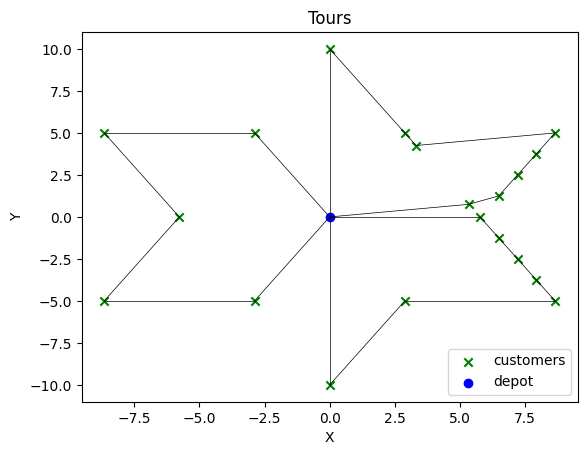

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gurobipy import *
Q = 200  # ship capacity
no_of_vehicles = 3  # no of ships
no_of_customers = 20
df = pd.read_csv(r'/content/OR_Lab_Datasheet.txt', sep = " ")
df = df.iloc[0:no_of_customers+1]

Y, X = list(df["Y"]), list(df["X"])
coordinates = np.column_stack((X, Y))


et, lt, st = list(df["et"]), list(df["lt"]), list(df["st"])  #time window constraints


Demand = list(df["Demand"])
n = len(coordinates)
print("COORDINATES:",n)
depot, customers = coordinates[0, :], coordinates[1:, :]
M = 100**100  # big number

m = Model("MVRP")
x, y, z = {}, {}, {}  #the decision variables

dist_matrix = np.empty([n, n])

print(len(X))
for i in range(len(X)):
    for j in range(len(Y)):
        x[i, j] = m.addVar(vtype=GRB.BINARY, name="x%d,%d" % (i, j))
        dist_matrix[i, j] = np.sqrt((X[i] - X[j]) ** 2 + (Y[i] - Y[j]) ** 2)
        if i == j:
            dist_matrix[i, j] = M  #Large Integer
        continue
m.update()

'''variable_2: y[j] = cumulative demand covered'''
for j in range(n):
    y[j] = m.addVar(vtype=GRB.INTEGER, name="y%d" % (j))   # cumulative demand satisfied variable
    z[j] = m.addVar(vtype=GRB.INTEGER, name="z%d" % (j))   # cumulative time variable
m.update()

'''constraint_1: sum(x[i,j]) = 1, for i = 1,2,...,32'''  # vehicles leaving each customer node
for i in range(n - 1):
    m.addConstr(quicksum(x[(i + 1, j)] for j in range(n)) == 1)
m.update()

''' constraint_2: sum(x[i,j] =1 for j = 1,2,.....,32)'''  # vehicles arriving to each customer node
for j in range(n - 1):
    m.addConstr(quicksum(x[(i, j + 1)] for i in range(n)) == 1)
m.update()

'''constraint_3: sum(x[0,j]) = 5'''  # vehicles leaving depot
m.addConstr(quicksum(x[(0, j)] for j in range(n)) == no_of_vehicles)
m.update()

'''constraint_4: sum(x[i,0]) = 5'''  # vehicles arriving to depot
m.addConstr(quicksum(x[(i, 0)] for i in range(n)) == no_of_vehicles)
m.update()

'''constraint_5: capacity of vehicle and also eliminating sub-tours'''
for j in range(n - 1):
    m.addConstr(y[j + 1] <= Q)
    m.addConstr(y[j + 1] >= Demand[j + 1])
    for i in range(n - 1):
        m.addConstr(y[j + 1] >= y[i + 1] + Demand[j + 1] * (x[i + 1, j + 1]) - Q * (1 - (x[i + 1, j + 1])))
m.update()


'''constraint_6: time-windows and also eliminating sub-tours'''

for i in range(n - 1):
    # service starts at 9:00 AM, 9 == 0 minutes, each hour after 9 is 60 minutes plus previous hours
    m.addConstr(z[i + 1] >= (et[i + 1] - 9) * 60)  # service should start after the earliest service start time
    m.addConstr(z[i + 1] <= (lt[i + 1] - 9) * 60)  # service can't be started after the latest service start time
    for j in range(n - 1):
        m.addConstr(z[i + 1] >= z[j + 1] + (st[j + 1] + dist_matrix[j + 1, i + 1]/100) * x[j + 1, i + 1] - M*(1-x[j+1, i+1]))
m.update()


'''objective function'''
m.setObjective(quicksum(quicksum(x[(i, j)]*dist_matrix[(i, j)] for j in range(n)) for i in range(n)),GRB.MINIMIZE)
m.update()

'''optimize'''
m.optimize()

'''retrieve the solution'''
sol_y, sol_x, sol_z = m.getAttr('x', y), m.getAttr('x', x), m.getAttr('x', z)
X, Y, Z = np.empty([n, n]), np.empty([n]), np.empty([n])
for i in range(n):
    Y[i] = sol_y[i]
    Z[i] = sol_z[i]
    for j in range(n):
        X[i, j] = int(sol_x[i, j])
print('\nObjective is:', m.objVal)
print('\nDecision variable X (binary decision of travelling from one node to another):\n', X.astype('int32'))
print('\nDecision variable z:(service start time of every location in minutes)\n', Z.astype('int32')[1:])
print('\nDecision variable y (cumulative demand collected at every location):\n', Y.astype('int32')[1:])


def plot_tours(solution_x):
    tours = [[i, j] for i in range(solution_x.shape[0]) for j in range(solution_x.shape[1]) if solution_x[i, j] ==1]
    for t, tour in enumerate(tours):
        plt.plot(df["X"][tour], df["Y"][tour], color = "black", linewidth=0.5)
    plt.scatter(df["X"][1:], df["Y"][1:], marker = 'x', color = 'g', label = "locations")
    plt.scatter(df["X"][0], df["Y"][0], marker = "o", color = 'b', label = "copenhagen")
    plt.xlabel("X"), plt.ylabel("Y"), plt.title("Tours"), plt.legend(loc = 4)
    plt.show()

plot_tours(X)

In [ ]:
dist_matrix.shape

(21, 21)

In [ ]:
print(dist_matrix)

[[1.00000000e+200 5.77350000e+000 5.77347702e+000 5.77352702e+000
  5.77350000e+000 5.77347702e+000 5.77352702e+000 1.00000398e+001
  1.00000000e+001 1.00000398e+001 1.00000398e+001 1.00000000e+001
  1.00000398e+001 5.39290648e+000 5.39291869e+000 6.61438758e+000
  7.63764660e+000 8.77974202e+000 6.61438758e+000 7.63764660e+000
  8.77974202e+000]
 [5.77350000e+000 1.00000000e+200 5.77352702e+000 1.00000398e+001
  1.15470000e+001 9.99995320e+000 5.77347702e+000 5.77352702e+000
  1.15470040e+001 1.52752932e+001 1.52752932e+001 1.15470040e+001
  5.77352702e+000 8.66019053e-001 4.90745797e+000 1.44338175e+000
  2.88676351e+000 4.33014526e+000 1.44338175e+000 2.88676351e+000
  4.33014526e+000]
 [5.77347702e+000 5.77352702e+000 1.00000000e+200 5.77350000e+000
  9.99995320e+000 1.15469540e+001 1.00000000e+001 5.77360000e+000
  5.77347702e+000 1.15470000e+001 1.52752482e+001 1.52752426e+001
  1.15470540e+001 4.90750797e+000 8.66069056e-001 7.21690877e+000
  8.66029053e+000 1.01036723e+001 5.20